In [1]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [2]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [3]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [5]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [6]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [7]:
# Define label mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [8]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [9]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [10]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [11]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tfidf_vectorizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tfidf_vectorizer = tfidf_vectorizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'Fire': 4,
            'anthropogenic': 5
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        # Image loading
        image_path = None
        for ext in ['.jpg', '.png', '.jpeg']:
            temp_path = os.path.join(self.images_folder, f"{image_id}{ext}")
            if os.path.exists(temp_path):
                image_path = temp_path
                break
        if image_path is None:
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)

        # TF-IDF vector
        tfidf_vector = self.tfidf_vectorizer.transform([text]).toarray().squeeze()  # shape: [feature_dim]

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'tfidf': torch.tensor(tfidf_vector, dtype=torch.float),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF vectorizer on training captions
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # You can tune max_features
tfidf_vectorizer.fit(train_data['caption'])  # Only fit on training data

# Paths
images_folder = '/kaggle/input/mddb-images/Photos_Final'

# Datasets
train_dataset = MultimodalDataset(train_data, images_folder, tfidf_vectorizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tfidf_vectorizer, valid_test_transforms)
test_dataset  = MultimodalDataset(test_data,  images_folder, tfidf_vectorizer, valid_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)


In [13]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [14]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class EarlyFusionModelTFIDF(nn.Module):
#     def __init__(self, num_classes=6, tfidf_dim=5000):
#         super(EarlyFusionModelTFIDF, self).__init__()

#         # Text branch: simple feedforward for TF-IDF vectors
#         self.text_branch = nn.Sequential(
#             nn.Linear(tfidf_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 768),  # Project to 768 to match image feature dim
#             nn.ReLU()
#         )

#         # Image branch: EfficientNet
#         self.efficientnet = models.efficientnet_b0(pretrained=True)
#         in_features = self.efficientnet.classifier[1].in_features
#         self.efficientnet.classifier = nn.Identity()  # Remove original classifier

#         # Project image features to 768 dimension
#         self.image_proj = nn.Linear(in_features, 768)

#         # Combined fully connected layers (classifier)
#         self.fc = nn.Sequential(
#             nn.Linear(768 + 768, 512),  # concat of text + image
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, text_features, image):
#         # text_features: [batch_size, tfidf_dim]
#         text_out = self.text_branch(text_features)

#         # image features
#         image_features = self.efficientnet(image)
#         image_features = self.image_proj(image_features)

#         # concatenate
#         combined = torch.cat((text_out, image_features), dim=1)
#         out = self.fc(combined)
#         return out


In [15]:
import torch
import torch.nn as nn
from torchvision import models

class EarlyFusionModelTFIDFWithCoAttention(nn.Module):
    def __init__(self, num_classes=6, tfidf_dim=5000, hidden_dim=768, num_heads=4):
        super(EarlyFusionModelTFIDFWithCoAttention, self).__init__()

        self.hidden_dim = hidden_dim

        # Project TF-IDF to hidden dimension
        self.text_proj = nn.Sequential(
            nn.Linear(tfidf_dim, hidden_dim),
            nn.ReLU()
        )

        # Text Self-Attention (optional, can be identity)
        self.text_self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Image feature extractor
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()
        self.image_proj = nn.Linear(in_features, hidden_dim)

        # Co-Attention (image ↔ text)
        self.image_to_text_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.text_to_image_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Final classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_input, image):
        B = text_input.size(0)

        # ----- TEXT PATH -----
        text_embed = self.text_proj(text_input).unsqueeze(1)  # [B, 1, hidden]
        text_embed, _ = self.text_self_attn(text_embed, text_embed, text_embed)

        # ----- IMAGE PATH -----
        image_feat = self.efficientnet(image)                # [B, feat]
        image_embed = self.image_proj(image_feat).unsqueeze(1)  # [B, 1, hidden]

        # ----- CO-ATTENTION -----
        # Image attends to text
        image_attended, _ = self.image_to_text_attn(image_embed, text_embed, text_embed)
        # Text attends to image
        text_attended, _ = self.text_to_image_attn(text_embed, image_embed, image_embed)

        # ----- CONCAT & CLASSIFY -----
        combined = torch.cat([text_attended.squeeze(1), image_attended.squeeze(1)], dim=1)
        out = self.fc(combined)
        return out


In [17]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EarlyFusionModelTFIDFWithCoAttention(num_classes=6, tfidf_dim=500).to(device)  # Use your actual tfidf_dim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop with early stopping
num_epochs = 10
patience = 3
early_stop_counter = 0
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        text_features = batch['tfidf'].to(device)  # TF-IDF vectors
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(text_features, images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * text_features.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            text_features = batch['tfidf'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(text_features, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * text_features.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")

    scheduler.step(valid_loss)

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load(best_model_path))
# model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]
<ipython-input-17-907590d209ab>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', a

Epoch 1/10, Train Loss: 1.7831, Val Loss: 1.7565


Epoch 2/10: 100%|██████████| 119/119 [00:39<00:00,  3.00it/s]


Epoch 2/10, Train Loss: 1.6442, Val Loss: 1.4454


Epoch 3/10: 100%|██████████| 119/119 [00:39<00:00,  3.01it/s]


Epoch 3/10, Train Loss: 1.2609, Val Loss: 1.0262


Epoch 4/10: 100%|██████████| 119/119 [00:39<00:00,  3.04it/s]


Epoch 4/10, Train Loss: 1.0257, Val Loss: 0.8862


Epoch 5/10: 100%|██████████| 119/119 [00:39<00:00,  3.04it/s]


Epoch 5/10, Train Loss: 0.8700, Val Loss: 0.7604


Epoch 6/10: 100%|██████████| 119/119 [00:38<00:00,  3.06it/s]


Epoch 6/10, Train Loss: 0.6875, Val Loss: 0.6431


Epoch 7/10: 100%|██████████| 119/119 [00:39<00:00,  3.00it/s]


Epoch 7/10, Train Loss: 0.6143, Val Loss: 0.5629


Epoch 8/10: 100%|██████████| 119/119 [00:38<00:00,  3.08it/s]


Epoch 8/10, Train Loss: 0.4707, Val Loss: 0.5356


Epoch 9/10: 100%|██████████| 119/119 [00:38<00:00,  3.09it/s]


Epoch 9/10, Train Loss: 0.4006, Val Loss: 0.5193


Epoch 10/10: 100%|██████████| 119/119 [00:38<00:00,  3.10it/s]


Epoch 10/10, Train Loss: 0.3665, Val Loss: 0.5146


<ipython-input-17-907590d209ab>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>


Test Set Evaluation:
Accuracy: 0.8170
Precision: 0.8205
Recall: 0.8170
F1 Score: 0.8156

Classification Report:
               precision    recall  f1-score   support

        flood       0.78      0.92      0.84       114
      cyclone       0.80      0.71      0.75        93
   earthquake       0.77      0.92      0.84        84
river erosion       0.85      0.75      0.80       101
         fire       0.89      0.86      0.87       112
anthropogenic       0.82      0.75      0.78       130

     accuracy                           0.82       634
    macro avg       0.82      0.82      0.82       634
 weighted avg       0.82      0.82      0.82       634



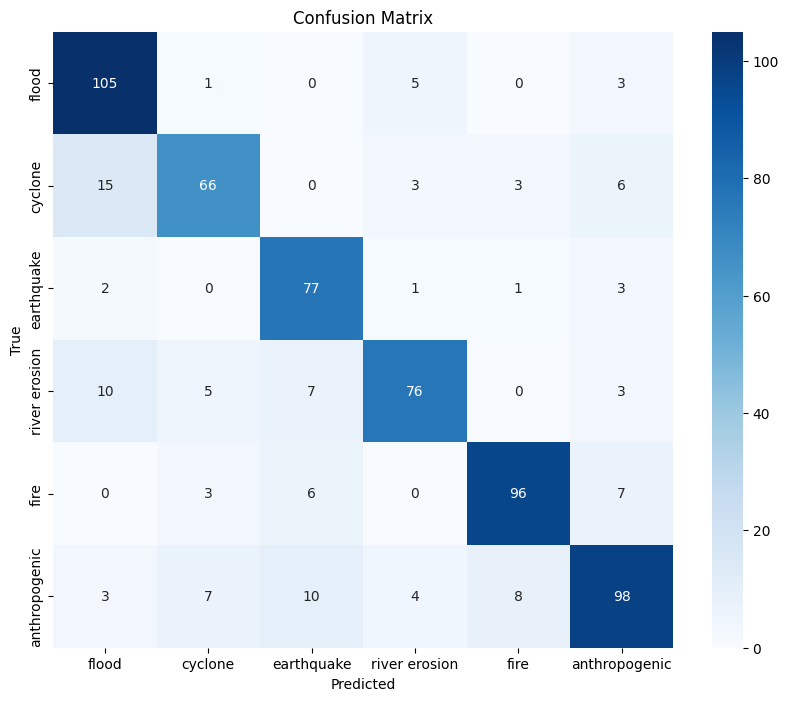

In [18]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        text_features = batch['tfidf'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(text_features, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


📉 Epoch-wise Losses:
Epoch  1: Train Loss = 1.7831, Val Loss = 1.7565
Epoch  2: Train Loss = 1.6442, Val Loss = 1.4454
Epoch  3: Train Loss = 1.2609, Val Loss = 1.0262
Epoch  4: Train Loss = 1.0257, Val Loss = 0.8862
Epoch  5: Train Loss = 0.8700, Val Loss = 0.7604
Epoch  6: Train Loss = 0.6875, Val Loss = 0.6431
Epoch  7: Train Loss = 0.6143, Val Loss = 0.5629
Epoch  8: Train Loss = 0.4707, Val Loss = 0.5356
Epoch  9: Train Loss = 0.4006, Val Loss = 0.5193
Epoch 10: Train Loss = 0.3665, Val Loss = 0.5146


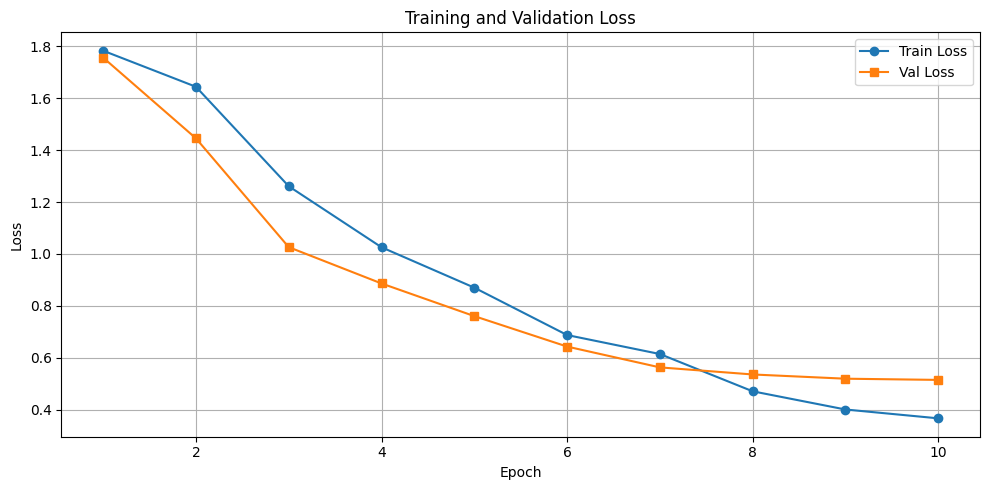

In [19]:
import matplotlib.pyplot as plt

# Print epoch-wise losses
print("\n📉 Epoch-wise Losses:")
for i, (train, val) in enumerate(zip(train_losses, valid_losses), start=1):
    print(f"Epoch {i:2d}: Train Loss = {train:.4f}, Val Loss = {val:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Val Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
